In [5]:
import json

# Load JSON data
with open('filtered_dataset.json.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Determine structure and count entries
if isinstance(data, dict):
    # If top-level is dict, check if values are dicts (nested structure)
    total_count = 0
    nested_counts = {}
    for key, val in data.items():
        if isinstance(val, dict):
            count = len(val)
            nested_counts[key] = count
            total_count += count
        else:
            # If value not dict, treat as single entry or ignore based on context
            nested_counts[key] = 1
            total_count += 1

    print("Counts per top-level key:")
    for k, cnt in nested_counts.items():
        print(f"  {k}: {cnt}")
    print(f"Total entries across all keys: {total_count}")

elif isinstance(data, list):
    total_count = len(data)
    print(f"Top-level is a list with {total_count} entries.")
else:
    # Other types
    print(f"Top-level JSON is of type {type(data)}, count is 1.")

Counts per top-level key:
  DRIVERS_LICENCE.AUS.NSW.LEARNER.V1: 48
  DRIVERS_LICENCE.AUS.TAS.FULL.V1: 42
  DRIVERS_LICENCE.AUS.NSW.HEAVY.V1: 36
  DRIVERS_LICENCE.AUS.NSW.PROVISIONAL.V1: 36
  DRIVERS_LICENCE.AUS.TAS.HEAVY.V1: 23
  DRIVERS_LICENCE.AUS.NSW.FULL.V1: 22
  DRIVERS_LICENCE.AUS.SA.FULL.V1: 20
  DRIVERS_LICENCE.AUS.VIC.HEAVY.V1: 16
  DRIVERS_LICENCE.AUS.VIC.PROVISIONAL.V1: 15
  DRIVERS_LICENCE.AUS.TAS.LEARNER.V1: 17
  DRIVERS_LICENCE.AUS.VIC.FULL.V1: 16
  DRIVERS_LICENCE.AUS.SA.PROVISIONAL.V1: 14
  DRIVERS_LICENCE.AUS.QLD.FULL.V1: 14
Total entries across all keys: 319


In [33]:
import re
import json
import time
import boto3
import pandas as pd
from json import JSONDecoder, JSONDecodeError
from pydantic import BaseModel
import string

# ----------------------------
# 1. Configuration
# ----------------------------
DATA_PATH = 'filtered_keys_edit11 1.json'

REGION    = 'us-east-1'
MODEL_ARN = (
    "arn:aws:bedrock:us-east-1:597571589726:"
    "inference-profile/us.meta.llama4-maverick-17b-instruct-v1:0"
)


# Bedrock client & model
runtime  = boto3.client("bedrock-runtime", region_name=REGION)
model_id = MODEL_ARN

# The prompt to send to Bedrock
prompt_text = """
You are a document-reading assistant. 
I will give you a block of OCR’d text from a single document. 
Parse it and respond with a single JSON object with exactly these keys at the top level (no nesting):  
- name (full name as string)  
- address (string):  Dont treat 
- dateOfBirth (string in DD/MM/YYYY format; if not found, "")   
- dateOfIssue (string in DD/MM/YYYY format; if not found, "") 
- dateOfExpiry (string in DD/MM/YYYY format; if not found, "")  
- licenceNumber (string; if not found, "")  
- passportNumber (string; if not found, "")  
- cardNumber (string; if not found, "")   
- identityNumber (string; if not found, "")   
- non_pii_text (array of strings):        
For each non-empty line in the OCR text:       
• Remove any numeric substrings, dates, or identifiers after the first digit or slash.        
• Trim whitespace.      
• Keep only the label portion (static text before any digit or slash).        
• Do not include empty strings in the array. If a field isn’t present in the text, set its value to an empty string. 
Return only valid JSON: a flat object with exactly those keys, no extra nesting or commentary. 

Here is one example:
"0d4068c9-c6db-435d-9ed6-c0317ecddf62-enhanced-1_pt.json": {
      "pseudo": "Learner Driver Licence New South Wales, Australia\nChung Jenkins LAMBERT\n. Card Number 2 659 265 265\n95 QMXOYCPEVJZ RD IXTZQVT NSW 2282\nLicence No 57250351 Licence Class C LRN\nDate of Birth 06 JAN 1987\nExpiry Date 03 AUG 2027",
      "ground_truth": {
        "name": "Chung Jenkins LAMBERT",
        "address": "95 QMXOYCPEVJZ RD IXTZQVT NSW 2282",  
        "dateOfBirth": "06/01/1987",
        "dateOfIssue": "",
        "dateOfExpiry": "03/08/2027",
        "licenceNumber": "57250351",
        "passportNumber": "",
        "cardNumber": "2659265265",
        "identityNumber": "",
        "non_pii_text": [
          "Learner Driver Licence New South Wales, Australia",
          "Licence No",
          "Licence Class C LRN",
          "Date of Birth",
          "Expiry Date",
          "Card Number"
        ]
      }
    }

""".strip()


# ----------------------------
# 2. Pydantic model for validation
# ----------------------------
class RawDocumentInfo(BaseModel):
    name: str
    address: str
    dateOfBirth: str
    dateOfIssue: str
    dateOfExpiry: str
    licenceNumber: str
    passportNumber: str
    cardNumber: str
    identityNumber: str
    non_pii_text: list[str]

    @classmethod
    def __get_validators__(cls):
        yield from super().__get_validators__()
        yield cls._ensure_list

    @staticmethod
    def _ensure_list(v):
        return v or []

# ----------------------------
# 3. Function to parse a single OCR text block
# ----------------------------
def parse_document_text(input_text: str) -> dict:
    resp = runtime.converse(
        modelId=model_id,
        messages=[{"role": "user", "content": [{"text": prompt_text}, {"text": input_text}]}],
        inferenceConfig={"maxTokens": 512, "temperature": 0.0}
    )
    raw = resp["output"]["message"]["content"][0]["text"]

    # strip out control tokens and fences
    cleaned = re.sub(r"<\|.*?\|>", "", raw, flags=re.S)
    cleaned = re.sub(r"^```(?:json)?\s*", "", cleaned, flags=re.I)
    cleaned = re.sub(r"\s*```$", "", cleaned, flags=re.I)
    cleaned = cleaned.strip()

    # robust JSON parsing: raw_decode to ignore trailing
    decoder = JSONDecoder()
    parsed_json, end_idx = decoder.raw_decode(cleaned)
    trailing = cleaned[end_idx:].strip()
    if trailing:
        print(f"Warning: ignored trailing data: {repr(trailing[:100])}")

    if not isinstance(parsed_json, dict):
        raise ValueError(f"Expected a JSON object, got: {parsed_json!r}")

    # validate & normalize with Pydantic
    doc_info = RawDocumentInfo.parse_obj(parsed_json)
    return doc_info.dict()

# ----------------------------
# 4. Metric helper
# ----------------------------
def compute_metrics(tp: int, fp: int, fn: int):
    p = tp/(tp+fp) if tp+fp > 0 else 0.0
    r = tp/(tp+fn) if tp+fn > 0 else 0.0
    f = 2*p*r/(p+r) if p+r > 0 else 0.0
    return p, r, f


def normalize_label(label: str) -> str:
    l = label.strip()
    # remove all leading/trailing punctuation
    l = l.strip(string.punctuation)
    # collapse multiple internal spaces
    l = re.sub(r"\s+", " ", l)
    return l

# ----------------------------
# 5. Main loop: run, compare & collect metrics (including top-level key)
# ----------------------------
metrics_list = []

with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

for top_level_key, files in data.items():
    for file_id, record in files.items():
        ocr_text = record.get('pseudo', '').strip()
        if not ocr_text:
            continue

        start = time.time()
        predicted = parse_document_text(ocr_text)
        latency = time.time() - start

        # PII sets (as before)
        pii_fields = {
            predicted[k].strip()
            for k in ['name','address','dateOfBirth','dateOfIssue',
                      'dateOfExpiry','licenceNumber','passportNumber',
                      'cardNumber','identityNumber']
            if predicted.get(k, "").strip().lower()
        }
        gt = record.get('ground_truth', {}) or {}
        gt_pii = {
            gt[k].strip()
            for k in ['name','address','dateOfBirth','dateOfIssue',
                      'dateOfExpiry','licenceNumber','passportNumber',
                      'cardNumber','identityNumber']
            if gt.get(k, "").strip().lower()
        }

        # --- NEW: non-PII normalization block ---
        non_pii_fields = {
            normalize_label(x)
            for x in predicted.get('non_pii_text', [])
            if x.strip().lower()
        }
        gt_non_pii = {
            normalize_label(x)
            for x in gt.get('non_pii_text', [])
            if x.strip().lower()
        }
        # ------------------------------------------

        # compute PII metrics
        tp_pii = len(pii_fields & gt_pii)
        fp_pii = len(pii_fields - gt_pii)
        fn_pii = len(gt_pii - pii_fields)
        p_pii, r_pii, f1_pii = compute_metrics(tp_pii, fp_pii, fn_pii)

        # compute non-PII metrics
        tp_non = len(non_pii_fields & gt_non_pii)
        fp_non = len(non_pii_fields - gt_non_pii)
        fn_non = len(gt_non_pii - non_pii_fields)
        p_non, r_non, f1_non = compute_metrics(tp_non, fp_non, fn_non)

        total_gt = len(gt_pii) + len(gt_non_pii)
        accuracy = (tp_pii + tp_non) / total_gt if total_gt > 0 else 0.0

        metrics_list.append({
            'top_level_key': top_level_key,
            'file_id': file_id,
            'latency_s': round(latency, 2),
            'p_pii': round(p_pii, 4),
            'r_pii': round(r_pii, 4),
            'f1_pii': round(f1_pii, 4),
            'p_non': round(p_non, 4),
            'r_non': round(r_non, 4),
            'f1_non': round(f1_non, 4),
            'accuracy': round(accuracy, 4),
        })

        # optional debug print
        print(f"{top_level_key} | {file_id} | tp_non={tp_non}, fp_non={fp_non}, fn_non={fn_non}")

DRIVERS_LICENCE.AUS.NSW.LEARNER.V1 | 013c11b9-7bac-493a-8350-1cb8bbdaea79-1_pt.json | tp_non=4, fp_non=2, fn_non=2
DRIVERS_LICENCE.AUS.NSW.LEARNER.V1 | 01b2b7df-771a-47c4-a92c-7d8b64d75ad1-1_pt.json | tp_non=4, fp_non=1, fn_non=3
DRIVERS_LICENCE.AUS.NSW.LEARNER.V1 | 02a9909b-7795-4a6e-ba1b-cca8059af237-1_pt.json | tp_non=3, fp_non=1, fn_non=2
DRIVERS_LICENCE.AUS.NSW.LEARNER.V1 | 03cfea22-fb6e-4dae-8c1d-b969ff0d2a01-1_pt.json | tp_non=4, fp_non=2, fn_non=1
DRIVERS_LICENCE.AUS.NSW.LEARNER.V1 | 03e20df0-408a-44f7-901f-34280ba5f7dc-1_pt.json | tp_non=5, fp_non=1, fn_non=6
DRIVERS_LICENCE.AUS.NSW.LEARNER.V1 | 04c6ee14-f46b-44c2-bf23-4035e04bb465-enhanced-1_pt.json | tp_non=6, fp_non=2, fn_non=3
DRIVERS_LICENCE.AUS.NSW.LEARNER.V1 | 04c6ee14-f46b-44c2-bf23-4035e04bb465-raw-1_pt.json | tp_non=6, fp_non=1, fn_non=2
DRIVERS_LICENCE.AUS.NSW.LEARNER.V1 | 04dd75fb-b710-43c8-a6e4-cd7b48ba4f6c-1_pt.json | tp_non=5, fp_non=2, fn_non=6
DRIVERS_LICENCE.AUS.NSW.LEARNER.V1 | 0513d80b-1b12-4916-b444-ee767f

In [34]:
# ----------------------------
# 6. At end: show summary table
# ----------------------------
df = pd.DataFrame(metrics_list)


# Assuming you’ve already done:
# import pandas as pd
# df = pd.DataFrame(metrics_list)

# Add a new column “f1_combined” that combines f1_pii and f1_non.
# Here we take the harmonic mean (the usual F1 combination) of the two:
df['f1_combined'] = 2 * df['f1_pii'] * df['f1_non'] / (df['f1_pii'] + df['f1_non'])

# If you prefer a simple average instead, you could do:
# df['f1_combined'] = (df['f1_pii'] + df['f1_non']) / 2

# Inspect the first few rows
df

,top_level_key,file_id,latency_s,p_pii,r_pii,f1_pii,p_non,r_non,f1_non,accuracy,f1_combined
0,DRIVERS_LICENCE.AUS.NSW.LEARNER.V1,013c11b9-7bac-493a-8350-1cb8bbdaea79-1_pt.json,1.46,1.0000,1.0000,1.0000,0.6667,0.6667,0.6667,0.8333,0.800024
1,DRIVERS_LICENCE.AUS.NSW.LEARNER.V1,01b2b7df-771a-47c4-a92c-7d8b64d75ad1-1_pt.json,0.86,1.0000,1.0000,1.0000,0.8000,0.5714,0.6667,0.7692,0.800024
2,DRIVERS_LICENCE.AUS.NSW.LEARNER.V1,02a9909b-7795-4a6e-ba1b-cca8059af237-1_pt.json,0.86,0.8333,0.8333,0.8333,0.7500,0.6000,0.6667,0.7273,0.740748
3,DRIVERS_LICENCE.AUS.NSW.LEARNER.V1,03cfea22-fb6e-4dae-8c1d-b969ff0d2a01-1_pt.json,1.41,0.6667,0.8000,0.7273,0.6667,0.8000,0.7273,0.8000,0.727300
4,DRIVERS_LICENCE.AUS.NSW.LEARNER.V1,03e20df0-408a-44f7-901f-34280ba5f7dc-1_pt.json,0.85,1.0000,1.0000,1.0000,0.8333,0.4545,0.5882,0.6471,0.740713
...,...,...,...,...,...,...,...,...,...,...,...
314,DRIVERS_LICENCE.AUS.QLD.FULL.V1,02a13f57-d51f-4c70-9d9a-927a851b2b2b-1_pt.json,0.86,0.8571,0.8571,0.8571,0.7500,0.6667,0.7059,0.7500,0.774187
315,DRIVERS_LICENCE.AUS.QLD.FULL.V1,02c35531-59c0-4a53-a02f-4de8dce36117-1_pt.json,0.86,0.8571,0.8571,0.8571,0.8571,0.6667,0.7500,0.7500,0.799981
316,DRIVERS_LICENCE.AUS.QLD.FULL.V1,02d3808e-5f54-453b-afb0-5cb5a52d8e0e-1_pt.json,0.78,0.6000,0.6000,0.6000,0.8000,0.8000,0.8000,0.7333,0.685714
317,DRIVERS_LICENCE.AUS.QLD.FULL.V1,debug-mirza-1_pt.json,0.77,0.8000,0.8000,0.8000,0.8333,0.8333,0.8333,0.8182,0.816311


In [38]:
# 3. Calculate average of each numeric column
numeric_cols = ['latency_s', 'p_pii', 'r_pii', 'f1_pii', 'p_non', 'r_non', 'f1_non', 'accuracy']
averages = df[numeric_cols].mean().to_frame(name='average').T

print("=== Average Metrics ===")
print(averages)

=== Average Metrics ===
         latency_s     p_pii     r_pii    f1_pii    p_non  r_non    f1_non  \
average   1.038464  0.898595  0.903476  0.900255  0.86228   0.85  0.850836   

         accuracy  
average  0.873255  


In [39]:
import pandas as pd



# Group by top-level key and compute mean of f1_pii, f1_non, and accuracy
grouped = (
    df
    .groupby('top_level_key')[['f1_pii', 'f1_non', 'accuracy',"f1_combined"]]
    .mean()
    .reset_index()
)

# Show the result
print("=== Mean f1_pii, f1_non, accuracy by top_level_key ===")
print(grouped)

=== Mean f1_pii, f1_non, accuracy by top_level_key ===
                             top_level_key    f1_pii    f1_non  accuracy  \
0          DRIVERS_LICENCE.AUS.NSW.FULL.V1  0.818159  0.824186  0.826764   
1         DRIVERS_LICENCE.AUS.NSW.HEAVY.V1  0.939803  0.863317  0.886286   
2       DRIVERS_LICENCE.AUS.NSW.LEARNER.V1  0.935281  0.763233  0.844710   
3   DRIVERS_LICENCE.AUS.NSW.PROVISIONAL.V1  0.826894  0.771178  0.799772   
4          DRIVERS_LICENCE.AUS.QLD.FULL.V1  0.779593  0.763829  0.775521   
5           DRIVERS_LICENCE.AUS.SA.FULL.V1  0.920910  0.964065  0.948685   
6    DRIVERS_LICENCE.AUS.SA.PROVISIONAL.V1  0.907793  0.920893  0.922579   
7          DRIVERS_LICENCE.AUS.TAS.FULL.V1  0.899762  0.952600  0.922752   
8         DRIVERS_LICENCE.AUS.TAS.HEAVY.V1  0.938539  0.891917  0.915387   
9       DRIVERS_LICENCE.AUS.TAS.LEARNER.V1  0.841241  0.768700  0.804618   
10         DRIVERS_LICENCE.AUS.VIC.FULL.V1  0.947731  0.887356  0.916019   
11        DRIVERS_LICENCE.AUS.VIC

In [40]:
df.to_csv('latest_metrics_summary_llame4.csv', index=False)

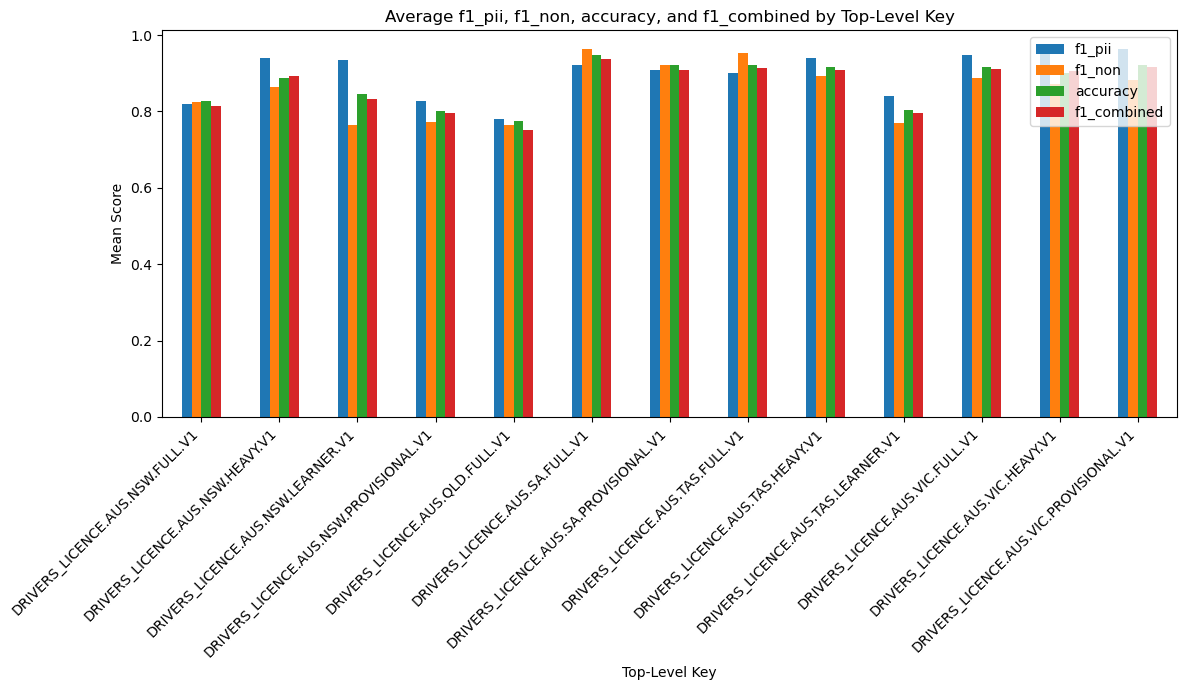

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by the top‐level key and average the four metrics
grouped = df.groupby('top_level_key')[['f1_pii','f1_non','accuracy','f1_combined']].mean()

# Plot
ax = grouped.plot(kind='bar', figsize=(12,7))
ax.set_title('Average f1_pii, f1_non, accuracy, and f1_combined by Top-Level Key')
ax.set_xlabel('Top-Level Key')
ax.set_ylabel('Mean Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [42]:
# optionally: save to CSV
df.to_csv('latest_metrics_summary_llema_4.csv', index=False)